## TRUE Graphene Pore Workflow

### Background
Graphene is a suitable material for electrodes due to their high specific surface area (SSA).  Often, the interactions between graphene pores and fluid molecules are studied with MD simulations through the use of slit pore models.  The goal of this notebook is to highlight how we can simulate a graphene slit pore system in a transparent, reproducible, extensible, and usable by others (TRUE) manner.

### Simulation Workflow
- Initialize system with mBuild with the use of `MOL2` files and the `Pore-Builder` package
- Parametrize system with Foyer
- Energy minimization, NVT equilibration, and NVT sampling with GROMACS 2018.5
- Data analysis and visualization with MDTraj and Matplotlib

#### Import packages

In [1]:
import mbuild as mb
import matplotlib.pyplot as plt
import numpy as np
import mdtraj as md
from foyer import Forcefield
from calc_numberdensity import calc_number_density

Illegal line #1
	" matplotlib 2.x
"
	in file "/Users/raymatsumoto/science/true_workflows/true_graphene/matplotlibrc"


#### Load in the water molecule and ions as mBuild Compounds

In [ ]:
water = mb.load('files/tip3p.mol2')
water.name = 'SOL'

na = mb.load('files/na.mol2')
na.name = 'Na'
cl = mb.load('files/cl.mol2')
cl.name = 'Cl'

#### Load in a separate `Forcefield` object for the graphene, water, and ions

In [ ]:
c_ff = Forcefield('files/carbon.xml')
spce = Forcefield('files/spce.xml')
jc = Forcefield('files/jc_spce.xml')

#### Importing Graphene Pores
To run this notebook, you will have to clone the pore-builder repository from GitHub: https://github.com/rmatsum836/Pore-Builder

In [ ]:
try:
    GraphenePoreSolvent = mb.recipes.GraphenePoreSolvent
except (ImportError, AttributeError):
    try:
        import porebuilder
        GraphenePoreSolvent = porebuilder.porebuilder.GraphenePoreSolvent
    except ImportError:
        pass

#### Initialize system
Here we call `GraphenePoreSolvent` to initialize a system with two graphene slit pores, 600 water molecules, and 200 ions

In [ ]:
system = GraphenePoreSolvent(pore_depth=5,
                             side_dim=4,
                             n_sheets=3,
                             pore_width=1.5,
                             x_bulk=6,
                             solvent=[water,na,cl],
                             n_solvent=[5200,400,400])

box = mb.Box(system.periodicity)

#### Separate molecules into different compounds
Because we are going to apply multiple force fields, we need to separate the waters and graphene into separate mBuild compounds.  Calling `apply` will apply the forcefield to the compounds and convert them to parametrized ParmEd `Structures`

In [ ]:
water = mb.Compound()
ions = mb.Compound()
graphene = mb.Compound()
for child in system.children:
    if child.name == 'SOL':
        water.add(mb.clone(child))
    elif child.name in ['Na', 'Cl']:
        ions.add(mb.clone(child))
    else:
        graphene.add(mb.clone(child))

water_pmd = spce.apply(water, residues='SOL')      
ions_pmd = jc.apply(ions, residues=['Na', 'Cl'])
pore_pmd = c_ff.apply(graphene)

#### Now we will combine the two paramterezed ParmEd structures and save them as `gro` and `top` files

In [ ]:
system = water_pmd + pore_pmd + ions_pmd
system.box[:3] = box.maxs * 10.0
system.save('init.gro', overwrite=True, combine='all')
system.save('init.top', overwrite=True, combine='all')

#### Once our system is saved, we start by running energy minimization in GROMACS
We will first call `gmx grompp` to compile the input file for the simulation, and then call `gmx mdrun` to actually run the simulation.

In [ ]:
!gmx grompp -f files/em.mdp -c init.gro -p init.top -o em.tpr
!gmx mdrun -v -deffnm em

#### Next we create a separate group for fluids using `gmx make_ndx`

In [ ]:
!(echo q && echo 12) | gmx make_ndx -f init.gro -o index.ndx

#### Next we run a short NVT equilibration of our system
We will first call `gmx grompp` to compile the input file for the simulation, and then call `gmx mdrun` to actually run the simulation.

In [ ]:
!gmx grompp -f files/nvt.mdp -c em.gro -p init.top -n index.ndx -o nvt.tpr
!gmx mdrun -v -deffnm nvt

#### Next we will sample our system
We will first call `gmx grompp` to compile the input file for the simulation, and then call `gmx mdrun` to actually run the simulation.

In [ ]:
!gmx grompp -f files/sample.mdp -c nvt.gro -p init.top -n index.ndx -o sample.tpr
!gmx mdrun -v -deffnm sample

#### Load in reference data to compare to

In [2]:
reference = np.loadtxt('ref_data/numden.txt')

#### Set dimensions of system for calculation of number density profiles

In [3]:
box_range = [.838, 2.337] # Position of Graphene in the z-direction of system
mins = [6.61, 0, 0] # Minimum x coordinates of graphene sheets
maxs = [10.8501, 0, 0] # Maximum x coordinates of graphene sheets
area = 5.53 # Area in y and z directions

#### Plotting Number density
Using `calc_number_density` we can calculate and plot the number density profile of water in the slit pores.

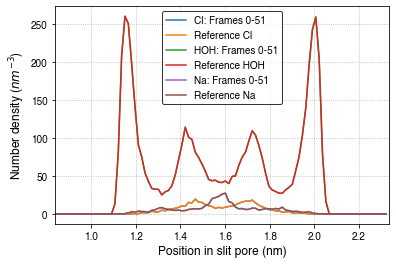

In [5]:
plt.figure()
plt.xlim(box_range[0], box_range[1])

# Load in files for MDTraj
gro_file = 'sample.gro'
trj_file = 'sample.trr'
top_file = 'init.top'

rho, bins, residues = calc_number_density(gro_file, trj_file, top_file, area, dim=1,
                                    box_range=box_range, n_bins=100, frame_range=range(0,51),
                                    maxs=maxs, mins=mins)
for res in range(3):
    plt.plot(bins, rho[res], label='{}: Frames {}-{}'.format(residues[res],0,51))
    plt.plot(reference[:,0], reference[:,res+1], label='Reference {}'.format(residues[res]))
plt.legend()
plt.ylabel(r'Number density ($nm^{-3}$)')
plt.xlabel('Position in slit pore (nm)')
plt.savefig('number-density.pdf')

In [ ]:
np.savetxt('ref_data/numden.txt',
                   np.transpose(np.vstack([bins, rho[0], rho[1], rho[2]])),
                   header='Position in slit pore(nm)\tCl\tHOH\tNa')

#### Results
From the results, we observe that the waters mainly exist at the walls of the slit pore at ~1.2 nm and ~2.0 nm respectively.  We also observe that some waters exist around the middle of the pore around ~1.4 nm and ~1.8 nm.  The ions in the pore don't appear to have any distinct ordering.  If the graphene was positively or negatively charged, we would expect different structure behavior of the ions.

#### Conclusions
Here we have demonstrated a TRUE simulation through the use of MoSDeF, GROMACS, and MDTraj.  Using mBuild and the `Graphene-Pore` mBuild recipe, the way in which this system is transparent, reproducible, and usable by others.  That is, a user can install these repositories and build this graphene system the same exact way that was done here.  The parametrization method is also transparent and reproducible, as the force field paramters are all contained within XML files that can be viewed by the user.  

Last but not least, this simulation workflow is easily extensible by others.  For example, system parameters such as pore width, water composition, and temperature can easily be changed to run similar simulations for comparison.